# tasc-poster
notebook for making plots for my tasc/kasc poster\
aim to make:
- Violin plots of overall prediction uncertainty
- Density of points in grid
- Emulation uncertainty over grid
- Posterior samples of hare with draws of noise
- Posterior samples for similar star compared to published values

In [126]:
# stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
import os

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner
from cmcrameri import cm

plt.style.use("dark_background")

# script imports
from scripts.pitchfuncs_ultra_pca import emulator
from scripts import prior_funcs, utils

## Import grid

In [272]:
df_full = pd.concat(
    [
        pd.read_hdf(
            "/home/oxs235/datastorage/repos_data/ojscutt/mesa_ajl/data/grid2p5a/grid.h5",
            key=f"m{0.8 + i*0.02:.2f}",
        )
        for i in range(21)
    ],
    ignore_index=True,
)
df = df_full[df_full["log_g"] >= 3.6]
df = df[df["star_age"] <= 14]
df = df[df["frac_age"] >= 0.015]

inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]
outputs = ["radius", "luminosity", "star_feh"] + [f"nu_0_{i}" for i in range(6, 41)]

df = df.loc[(df[[f"nu_0_{i}" for i in range(6, 41)]] != 0).all(axis=1)]

cols = inputs + outputs

df = df[cols]

df.dropna(inplace=True)

df["calc_effective_T"] = utils.calc_Teff(df["luminosity"], df["radius"])
df.describe()

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,star_feh,nu_0_6,nu_0_7,...,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,calc_effective_T
count,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,...,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06
mean,1.021885e+00,1.440698e-02,2.814693e-01,2.117984e+00,5.000177e+00,1.312728e+00,2.116482e+00,-1.127145e-01,7.726572e+02,8.860424e+02,...,3.590252e+03,3.696535e+03,3.802234e+03,3.907317e+03,4.011806e+03,4.115788e+03,4.219425e+03,4.322952e+03,4.426627e+03,5.866797e+03
std,1.175610e-01,9.677123e-03,2.805593e-02,2.879175e-01,3.405371e+00,4.813547e-01,1.572419e+00,3.499532e-01,2.959808e+02,3.426600e+02,...,1.408550e+03,1.451591e+03,1.494205e+03,1.536228e+03,1.577500e+03,1.617908e+03,1.657417e+03,1.696104e+03,1.734156e+03,5.670330e+02
min,8.000000e-01,3.869061e-03,2.400000e-01,1.700000e+00,2.966411e-02,6.990236e-01,1.321735e-01,-1.077903e+00,2.103102e+02,2.385545e+02,...,9.714892e+02,1.002125e+03,1.032723e+03,1.063221e+03,1.093511e+03,1.123625e+03,1.153506e+03,1.183191e+03,1.212653e+03,4.096930e+03
25%,9.200000e-01,6.471429e-03,2.600000e-01,1.900000e+00,2.309880e+00,9.719693e-01,9.371542e-01,-4.000000e-01,5.476978e+02,6.234189e+02,...,2.508813e+03,2.578850e+03,2.649156e+03,2.720741e+03,2.793748e+03,2.868279e+03,2.944027e+03,3.020312e+03,3.097018e+03,5.491841e+03
50%,1.040000e+00,1.077191e-02,2.800000e-01,2.100000e+00,4.275231e+00,1.160016e+00,1.698469e+00,-1.000000e-01,7.832912e+02,8.972267e+02,...,3.653209e+03,3.760636e+03,3.866328e+03,3.970106e+03,4.072429e+03,4.174203e+03,4.276548e+03,4.380549e+03,4.486487e+03,5.859776e+03
75%,1.120000e+00,2.007835e-02,3.000000e-01,2.300000e+00,7.159688e+00,1.498369e+00,2.883064e+00,1.837200e-01,9.935144e+02,1.142381e+03,...,4.644965e+03,4.784137e+03,4.922458e+03,5.059497e+03,5.194580e+03,5.327444e+03,5.458355e+03,5.587658e+03,5.716681e+03,6.219454e+03
max,1.200000e+00,3.897971e-02,3.200000e-01,2.500000e+00,1.399997e+01,2.873431e+00,1.163902e+01,5.094573e-01,1.480807e+03,1.705344e+03,...,6.936109e+03,7.145063e+03,7.354126e+03,7.562945e+03,7.771521e+03,7.979340e+03,8.185512e+03,8.382538e+03,8.584072e+03,7.993034e+03


In [273]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" + pitchfork_name + ".pkl", "rb") as fp:
    pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info["parameter_ranges"]

outputs = ["calc_effective_T", "luminosity", "star_feh"] + [
    f"nu_0_{i}" for i in range(6, 41)
]

df[["pred_" + output for output in outputs]] = pitchfork.predict(df[inputs].values)

df[["resid_" + output for output in outputs]] = (
    df[outputs].values - df[["pred_" + output for output in outputs]].values
)

df["mean_frac_error"] = np.mean(
    (np.abs(df[outputs].values - df[["pred_" + output for output in outputs]].values))
    / df[outputs].values
)

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


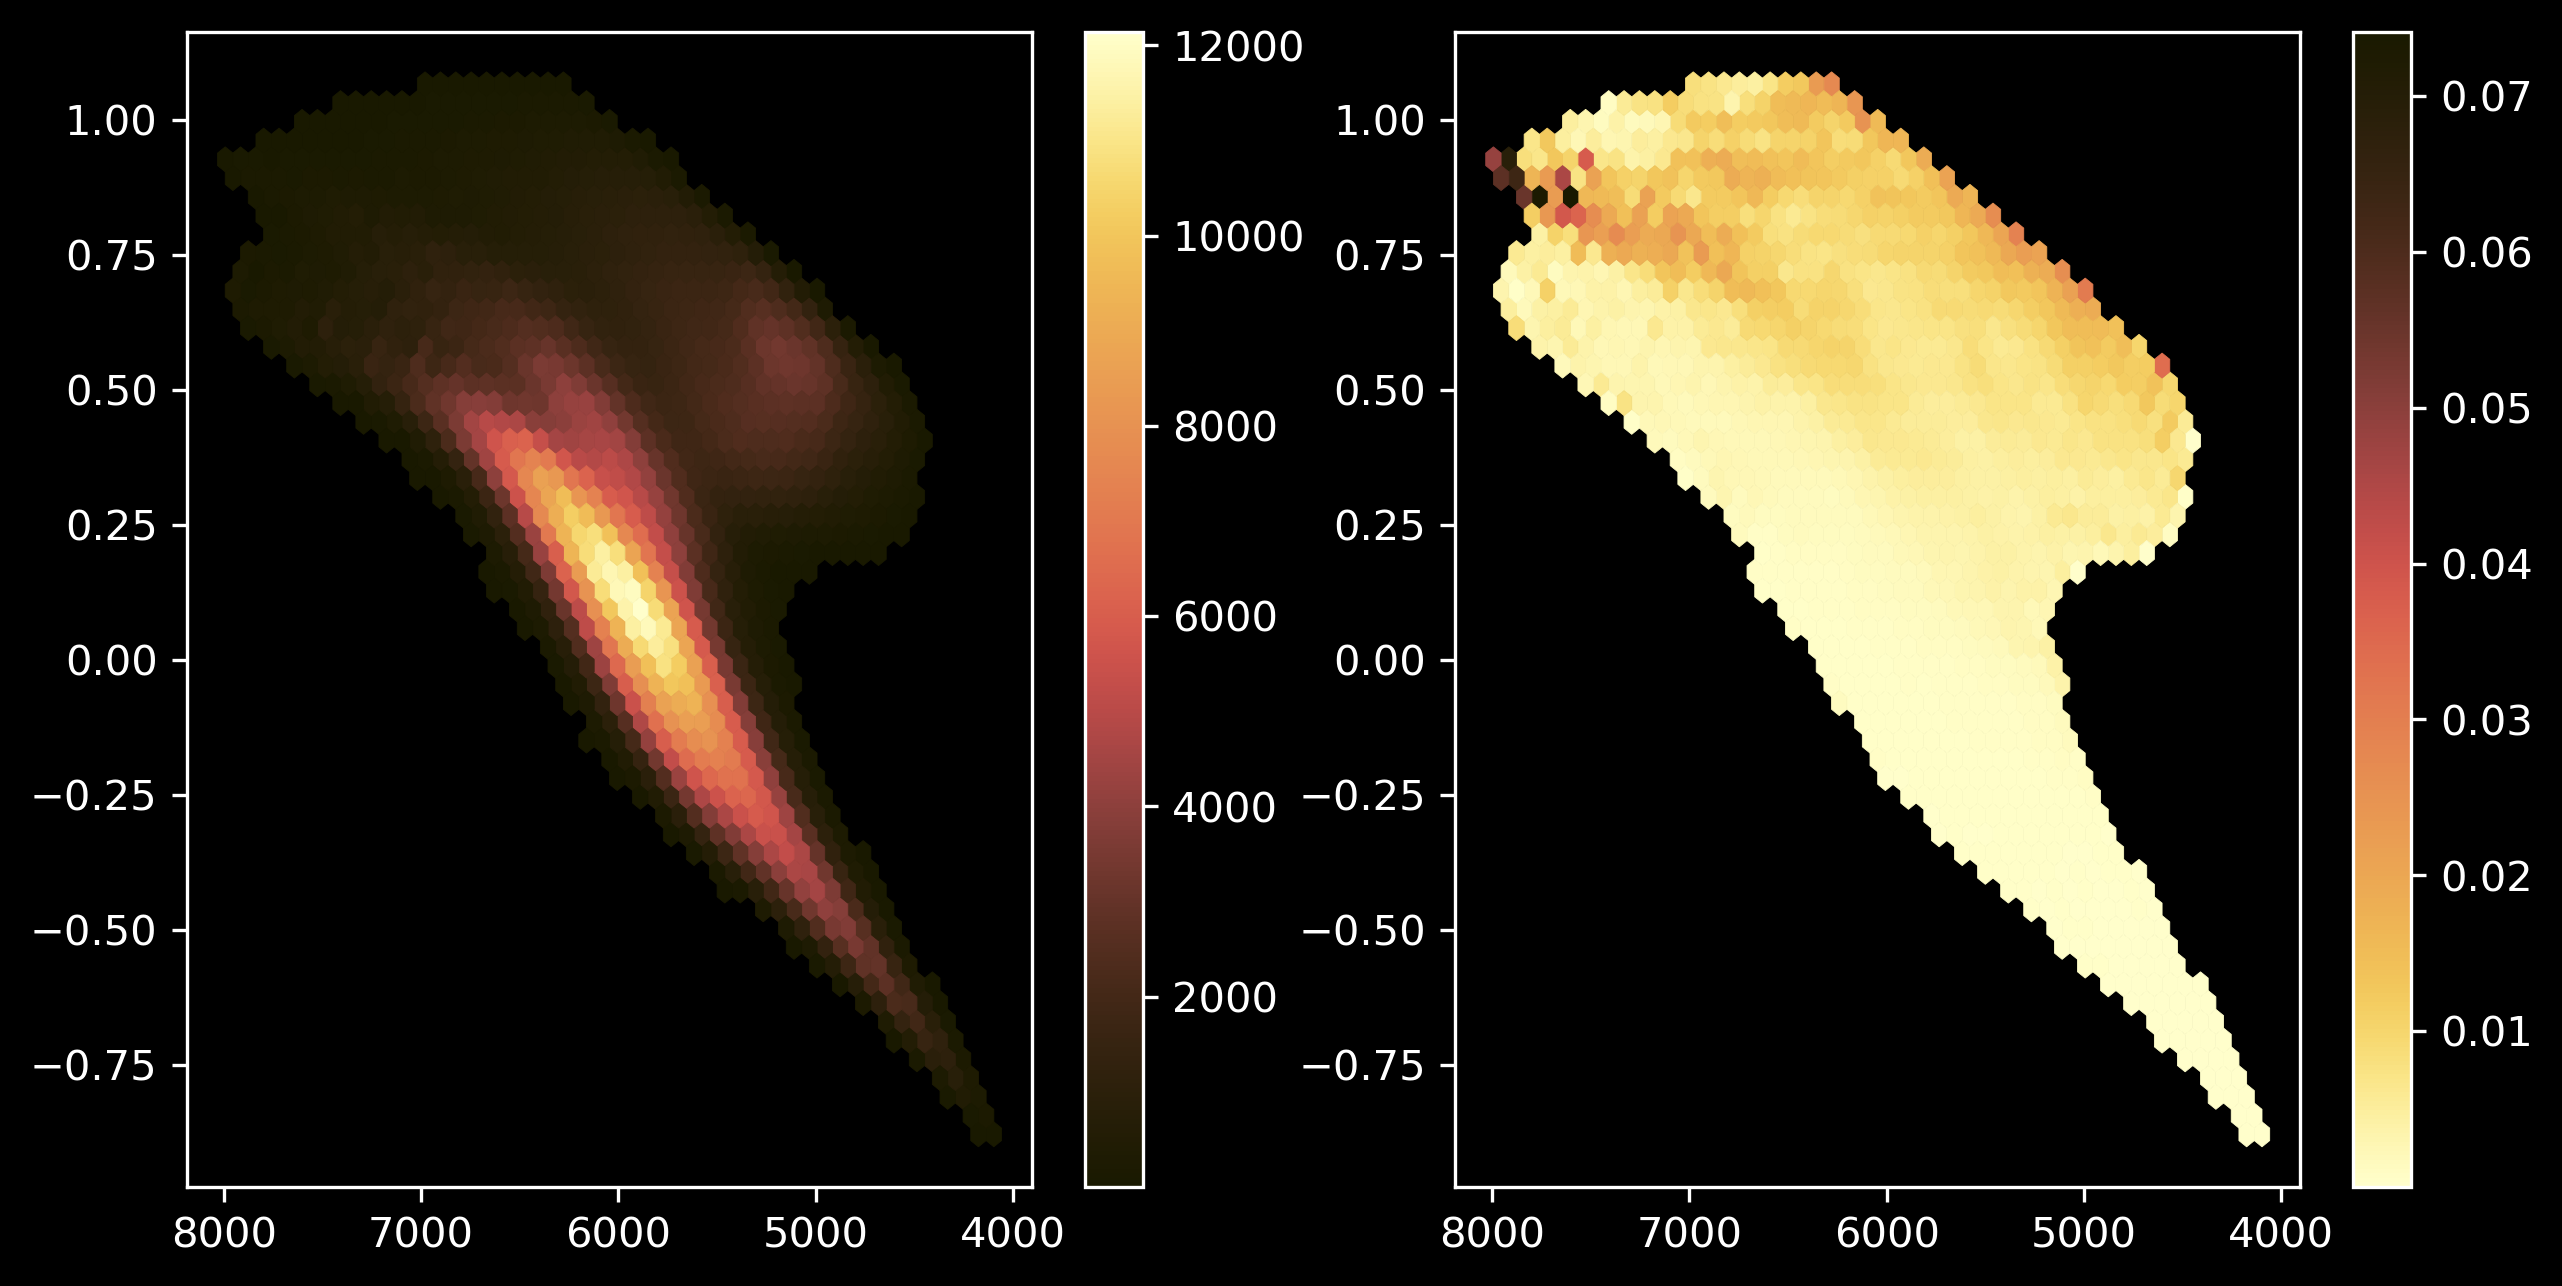

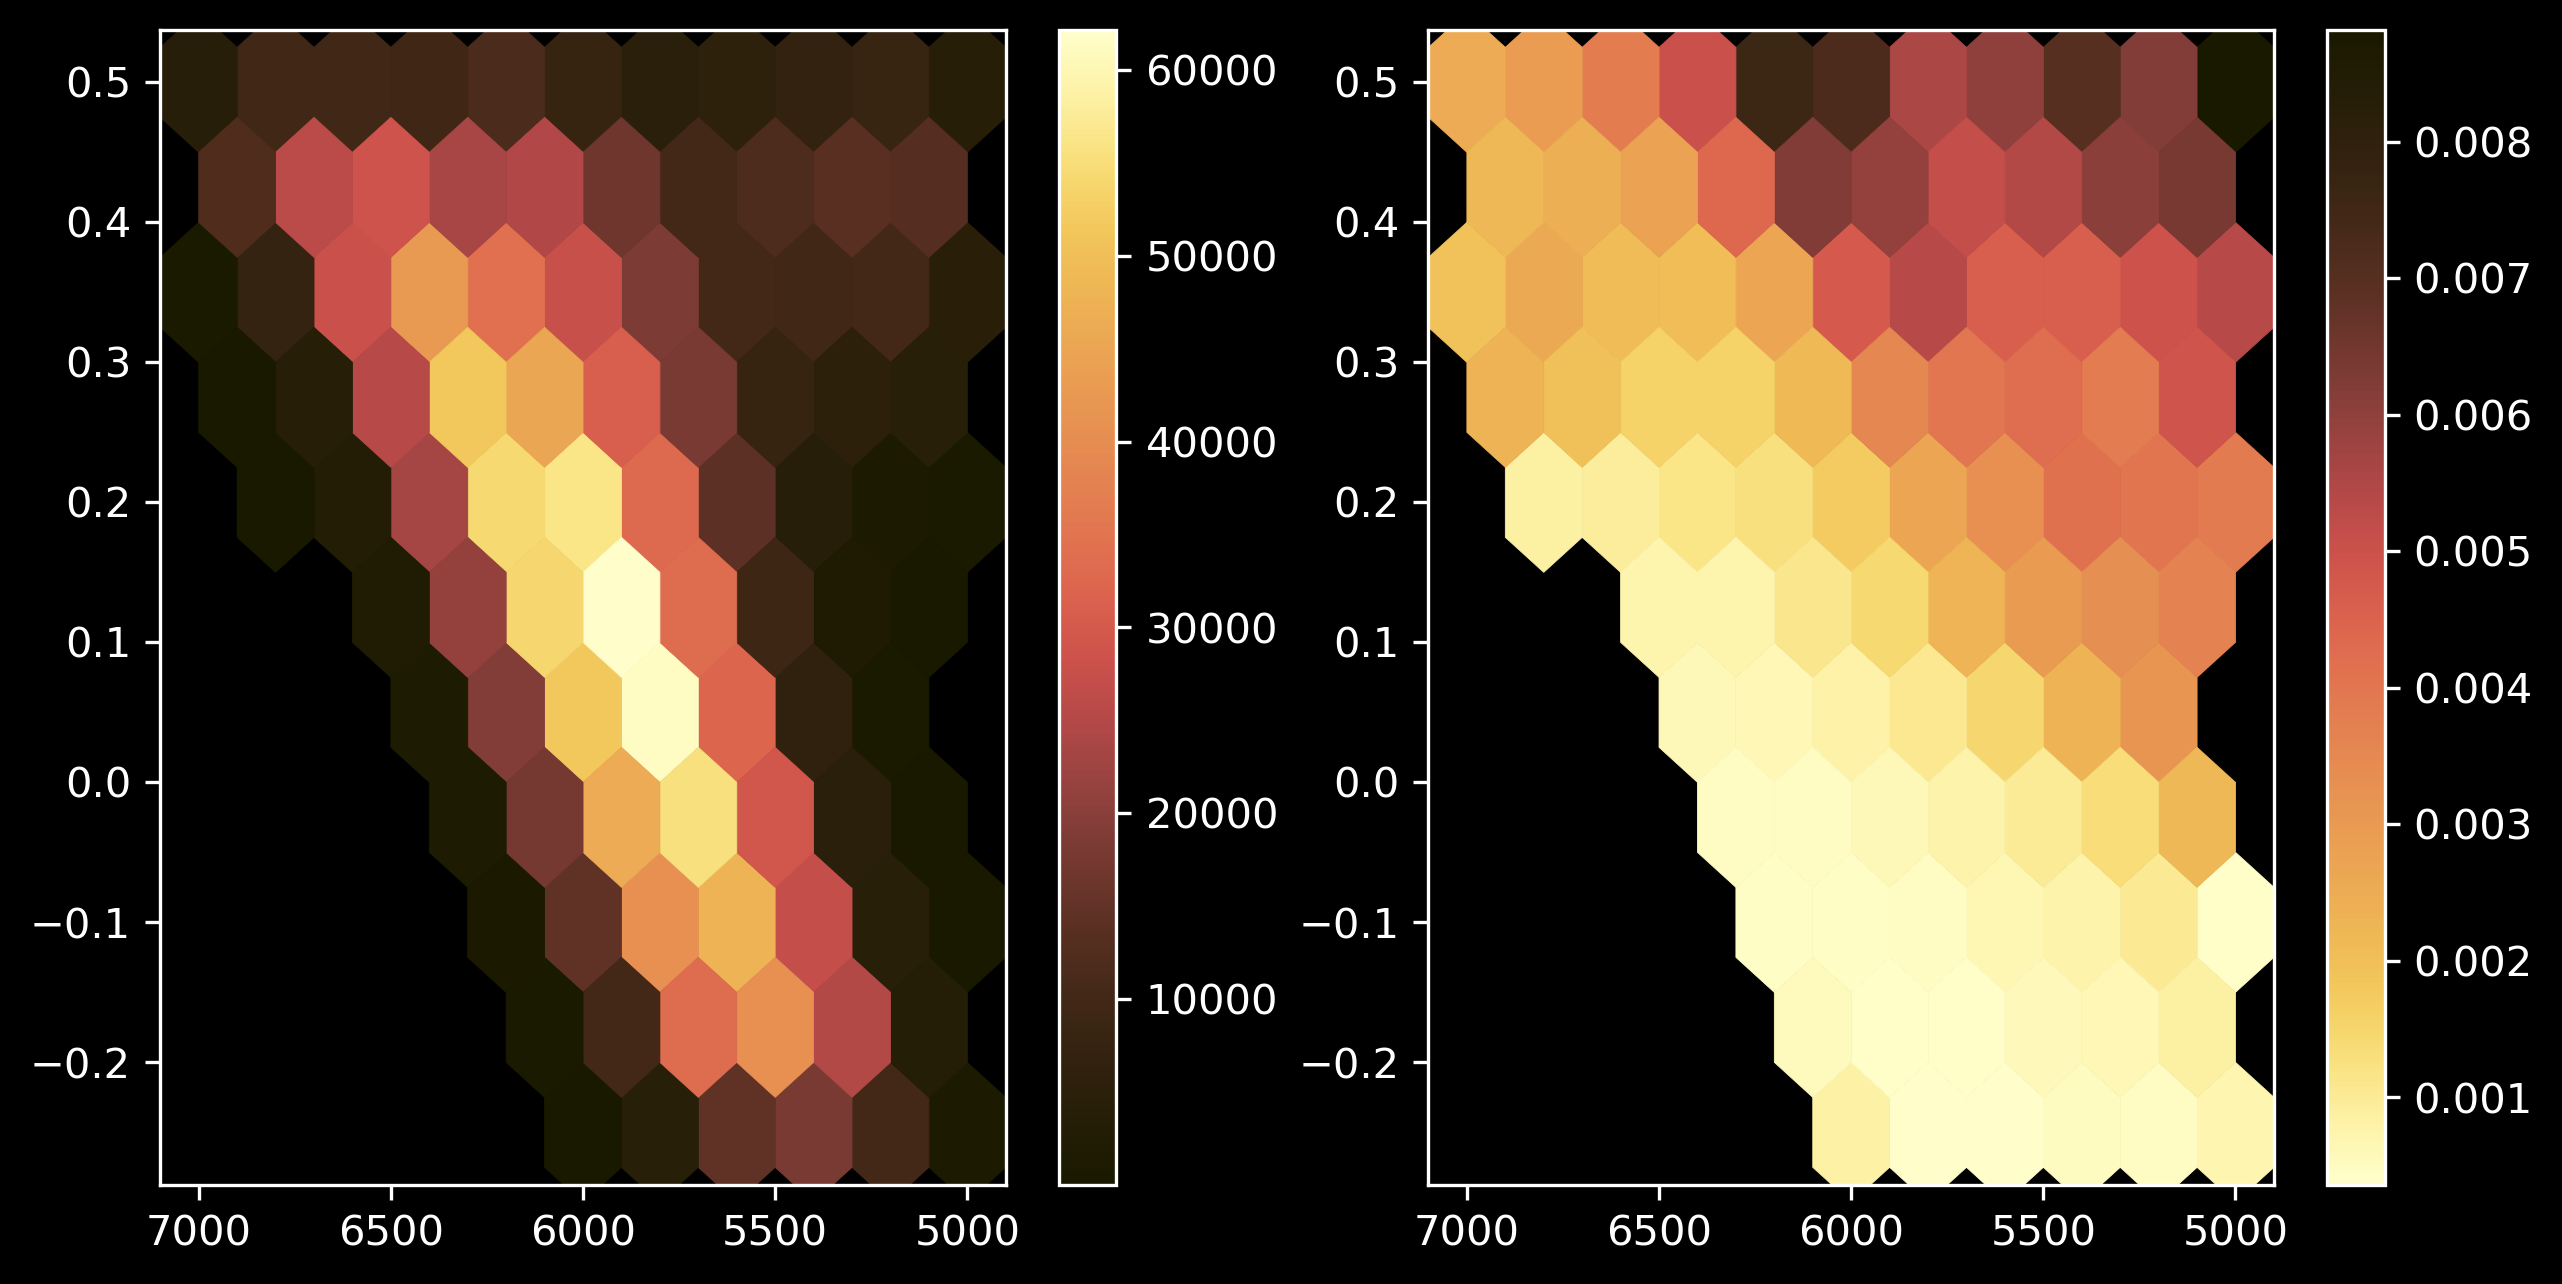

In [280]:
def comparison_hex(df, output, gridsize=100):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

    hex1 = ax1.hexbin(
        df["calc_effective_T"],
        np.log10(df["luminosity"]),
        cmap=cm.lajolla,
        gridsize=gridsize,
        mincnt=1,
        linewidths=0.2,
    )
    fig.colorbar(hex1)
    ax1.invert_xaxis()

    hex2 = ax2.hexbin(
        df["calc_effective_T"],
        np.log10(df["luminosity"]),
        C=df["resid_" + output],
        cmap=cm.lajolla_r,
        gridsize=gridsize,
        mincnt=2,
        linewidths=0.2,
        reduce_C_function=scipy.stats.median_abs_deviation,
    )
    fig.colorbar(hex2)
    ax2.invert_xaxis()


col_to_test = "luminosity"

comparison_hex(df, col_to_test, gridsize=50)

df_crop = df[df["calc_effective_T"].between(5000, 7000)]
df_crop = df_crop[df_crop["luminosity"].between(10 ** (-0.25), 10 ** (0.5))]

comparison_hex(df_crop, col_to_test, gridsize=10)

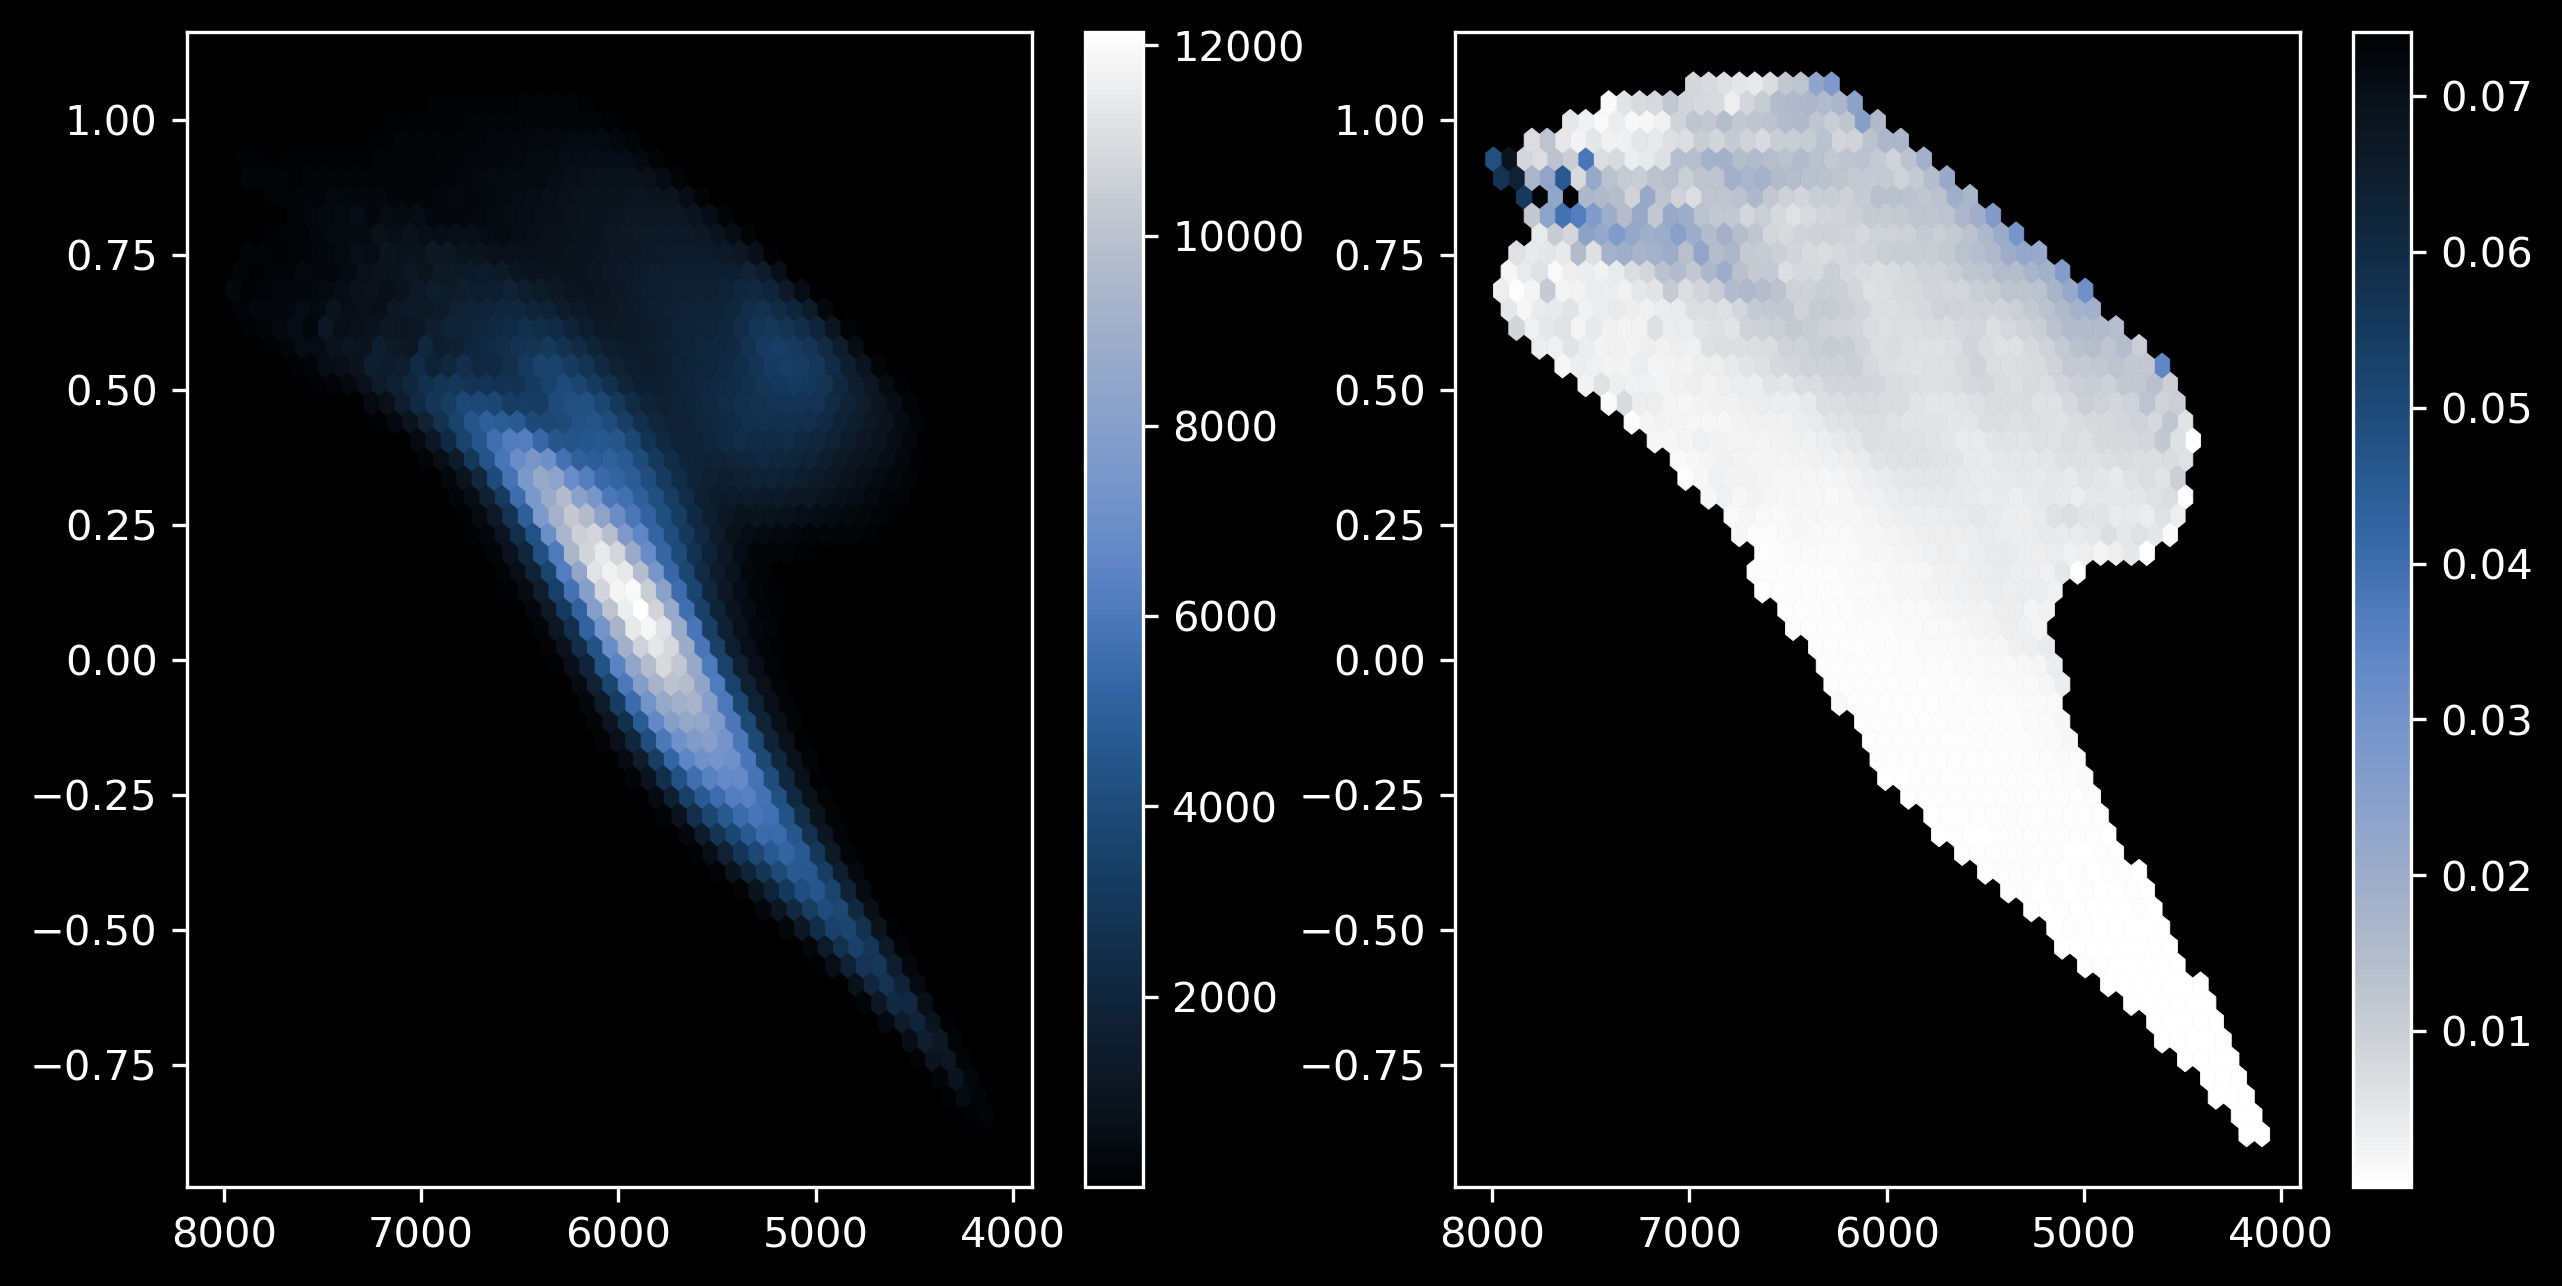

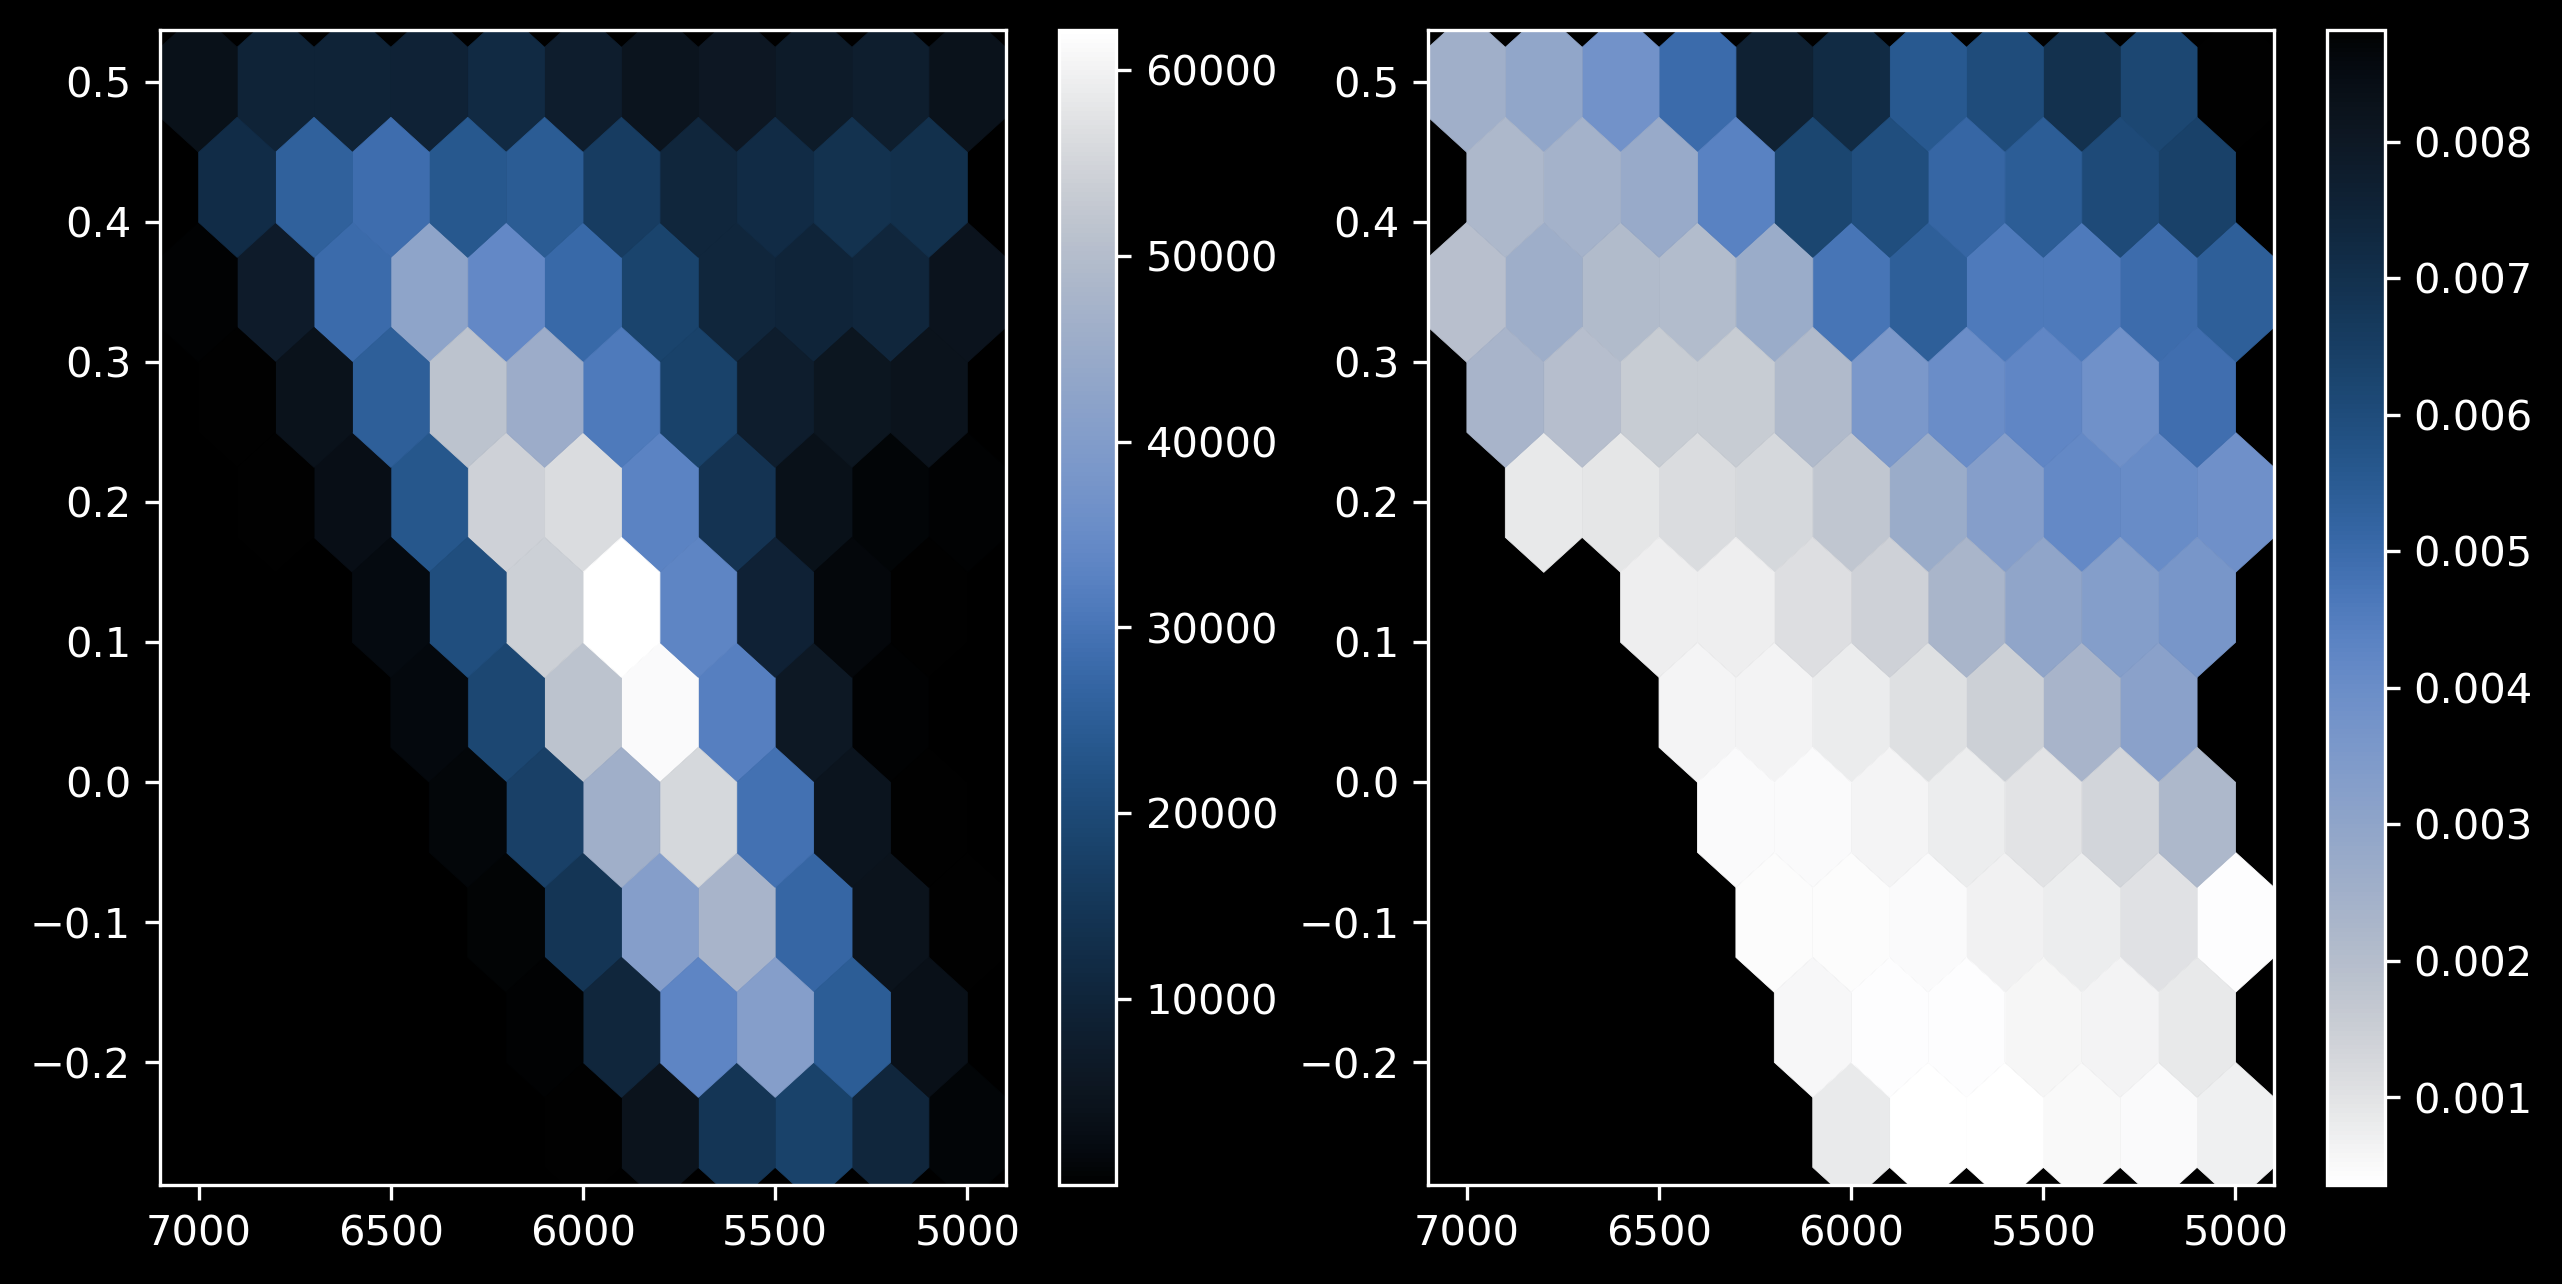

In [281]:
def comparison_hex(df, output, gridsize=100):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

    hex1 = ax1.hexbin(
        df["calc_effective_T"],
        np.log10(df["luminosity"]),
        cmap=cm.oslo,
        gridsize=gridsize,
        mincnt=1,
        linewidths=0.2,
    )
    fig.colorbar(hex1)
    ax1.invert_xaxis()

    hex2 = ax2.hexbin(
        df["calc_effective_T"],
        np.log10(df["luminosity"]),
        C=df["resid_" + output],
        cmap=cm.oslo_r,
        gridsize=gridsize,
        mincnt=2,
        linewidths=0.2,
        reduce_C_function=scipy.stats.median_abs_deviation,
    )
    fig.colorbar(hex2)
    ax2.invert_xaxis()


col_to_test = "luminosity"

comparison_hex(df, col_to_test, gridsize=50)

df_crop = df[df["calc_effective_T"].between(5000, 7000)]
df_crop = df_crop[df_crop["luminosity"].between(10 ** (-0.25), 10 ** (0.5))]

comparison_hex(df_crop, col_to_test, gridsize=10)

In [286]:
# Grid distributions
df_full = pd.concat(
    [
        pd.read_hdf(
            "/home/oxs235/datastorage/repos_data/ojscutt/mesa_ajl/data/grid2p5a/grid.h5",
            key=f"m{0.8 + i*0.02:.2f}",
        )
        for i in range(21)
    ],
    ignore_index=True,
)
df = df_full[df_full["log_g"] >= 3.6]
df = df[df["star_age"] <= 14]
df = df[df["frac_age"] >= 0.015]

inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]
outputs = ["radius", "luminosity", "star_feh"] + [f"nu_0_{i}" for i in range(6, 41)]

df = df.loc[(df[[f"nu_0_{i}" for i in range(6, 41)]] != 0).all(axis=1)]

cols = inputs + outputs

df = df[cols]

df.dropna(inplace=True)

df["calc_effective_T"] = utils.calc_Teff(df["luminosity"], df["radius"])
df.describe()

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,star_feh,nu_0_6,nu_0_7,...,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,calc_effective_T
count,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,...,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06
mean,1.021885e+00,1.440698e-02,2.814693e-01,2.117984e+00,5.000177e+00,1.312728e+00,2.116482e+00,-1.127145e-01,7.726572e+02,8.860424e+02,...,3.590252e+03,3.696535e+03,3.802234e+03,3.907317e+03,4.011806e+03,4.115788e+03,4.219425e+03,4.322952e+03,4.426627e+03,5.866797e+03
std,1.175610e-01,9.677123e-03,2.805593e-02,2.879175e-01,3.405371e+00,4.813547e-01,1.572419e+00,3.499532e-01,2.959808e+02,3.426600e+02,...,1.408550e+03,1.451591e+03,1.494205e+03,1.536228e+03,1.577500e+03,1.617908e+03,1.657417e+03,1.696104e+03,1.734156e+03,5.670330e+02
min,8.000000e-01,3.869061e-03,2.400000e-01,1.700000e+00,2.966411e-02,6.990236e-01,1.321735e-01,-1.077903e+00,2.103102e+02,2.385545e+02,...,9.714892e+02,1.002125e+03,1.032723e+03,1.063221e+03,1.093511e+03,1.123625e+03,1.153506e+03,1.183191e+03,1.212653e+03,4.096930e+03
25%,9.200000e-01,6.471429e-03,2.600000e-01,1.900000e+00,2.309880e+00,9.719693e-01,9.371542e-01,-4.000000e-01,5.476978e+02,6.234189e+02,...,2.508813e+03,2.578850e+03,2.649156e+03,2.720741e+03,2.793748e+03,2.868279e+03,2.944027e+03,3.020312e+03,3.097018e+03,5.491841e+03
50%,1.040000e+00,1.077191e-02,2.800000e-01,2.100000e+00,4.275231e+00,1.160016e+00,1.698469e+00,-1.000000e-01,7.832912e+02,8.972267e+02,...,3.653209e+03,3.760636e+03,3.866328e+03,3.970106e+03,4.072429e+03,4.174203e+03,4.276548e+03,4.380549e+03,4.486487e+03,5.859776e+03
75%,1.120000e+00,2.007835e-02,3.000000e-01,2.300000e+00,7.159688e+00,1.498369e+00,2.883064e+00,1.837200e-01,9.935144e+02,1.142381e+03,...,4.644965e+03,4.784137e+03,4.922458e+03,5.059497e+03,5.194580e+03,5.327444e+03,5.458355e+03,5.587658e+03,5.716681e+03,6.219454e+03
max,1.200000e+00,3.897971e-02,3.200000e-01,2.500000e+00,1.399997e+01,2.873431e+00,1.163902e+01,5.094573e-01,1.480807e+03,1.705344e+03,...,6.936109e+03,7.145063e+03,7.354126e+03,7.562945e+03,7.771521e+03,7.979340e+03,8.185512e+03,8.382538e+03,8.584072e+03,7.993034e+03


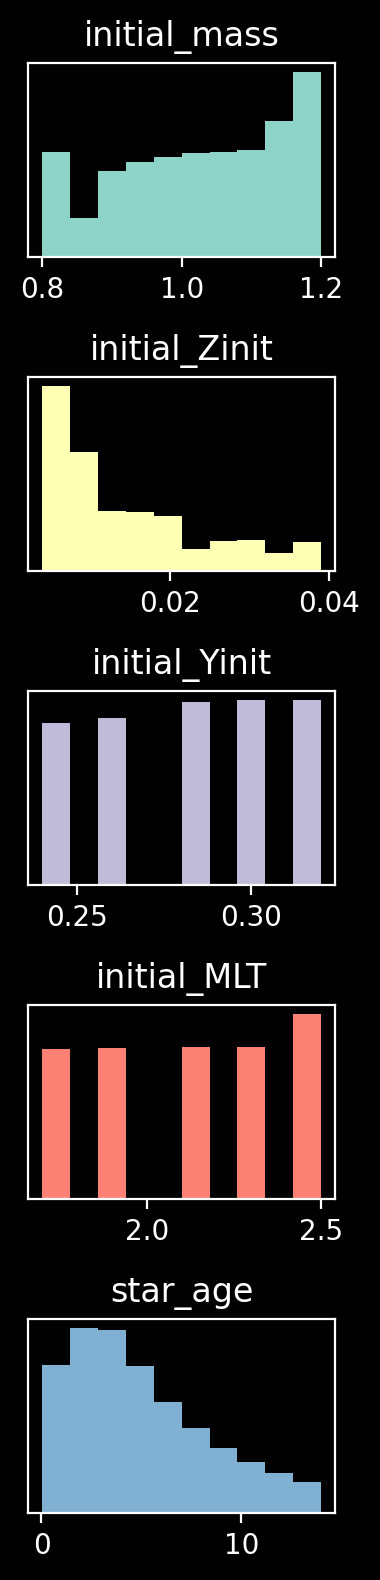

In [362]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(2, 8), dpi=200)


def grid_dist(ax, df, label, c):
    ax.hist(df[label], color=c)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_yticks([])
    ax.set_title(label)


colours = [colour["color"] for colour in plt.rcParams["axes.prop_cycle"]]

grid_dist(ax1, df, "initial_mass", colours[0])

grid_dist(ax2, df, "initial_Zinit", colours[1])

grid_dist(ax3, df, "initial_Yinit", colours[2])

grid_dist(ax4, df, "initial_MLT", colours[3])

grid_dist(ax5, df, "star_age", colours[4])

plt.tight_layout()
plt.show()

In [340]:
# Network classical output distributions
df_full = pd.concat(
    [
        pd.read_hdf(
            "/home/oxs235/datastorage/repos_data/ojscutt/mesa_ajl/data/grid2p5a/grid.h5",
            key=f"m{0.8 + i*0.02:.2f}",
        )
        for i in range(21)
    ],
    ignore_index=True,
)
df = df_full[df_full["log_g"] >= 3.6]
df = df[df["star_age"] <= 14]
df = df[df["frac_age"] >= 0.015]

inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]
outputs = ["radius", "luminosity", "star_feh"] + [f"nu_0_{i}" for i in range(6, 41)]

df = df.loc[(df[[f"nu_0_{i}" for i in range(6, 41)]] != 0).all(axis=1)]

cols = inputs + outputs

df = df[cols]

df.dropna(inplace=True)

df["calc_effective_T"] = utils.calc_Teff(df["luminosity"], df["radius"])
df.describe()

pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" + pitchfork_name + ".pkl", "rb") as fp:
    pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info["parameter_ranges"]

outputs = ["calc_effective_T", "luminosity", "star_feh"] + [
    f"nu_0_{i}" for i in range(6, 41)
]

df[["pred_" + output for output in outputs]] = pitchfork.predict(df[inputs].values)

df[["resid_" + output for output in outputs]] = (
    df[outputs].values - df[["pred_" + output for output in outputs]].values
)

df["mean_frac_error"] = np.mean(
    (np.abs(df[outputs].values - df[["pred_" + output for output in outputs]].values))
    / df[outputs].values
)

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


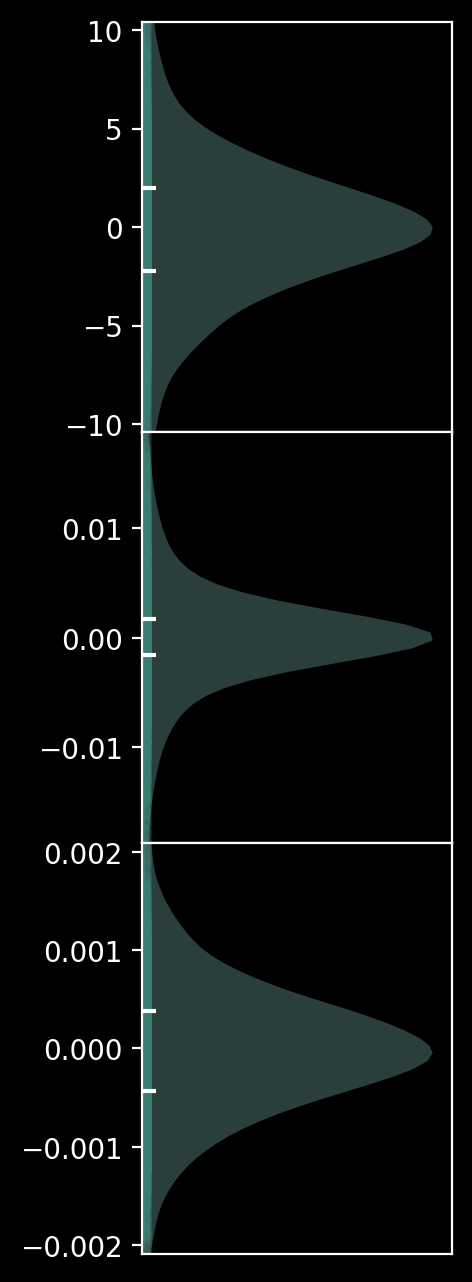

In [417]:
def classical_violins(df, labels, sample_n=10000):
    df = df.sample(n=sample_n)

    fig, axs = plt.subplots(len(labels), 1, figsize=(2, 8), dpi=200)

    def classical_violin(ax, label):
        residuals = df["resid_" + label]

        median = np.median(residuals, axis=0)
        violin = ax.violinplot(
            residuals,
            showextrema=False,
            showmedians=False,
            points=500,
            widths=1.5,
        )

        body = violin["bodies"][0]
        m = np.mean(body.get_paths()[0].vertices[:, 0])
        body.get_paths()[0].vertices[:, 0] = np.clip(
            body.get_paths()[0].vertices[:, 0], m, np.inf
        )

        ax.scatter(np.ones(len(residuals)), residuals, alpha=0.01)

        c = "white"
        ax.scatter(
            1,
            median + scipy.stats.median_abs_deviation(residuals),
            marker="_",
            c=c,
            s=100,
        )
        ax.scatter(
            1,
            median - scipy.stats.median_abs_deviation(residuals),
            marker="_",
            c=c,
            s=100,
        )

        ax.xaxis.set_tick_params(labelbottom=False)
        ax.set_xticks([])

        ylim = 0.1 * abs(max((residuals.min(), residuals.max()), key=abs))
        ax.set_ylim([-ylim, ylim])
        ax.set_xlim([1, 1.8])

    fig.subplots_adjust(hspace=0)

    ax_i = 0
    for label in labels:
        classical_violin(axs[ax_i], label)
        ax_i += 1


classical_violins(df, ["calc_effective_T", "luminosity", "star_feh"])

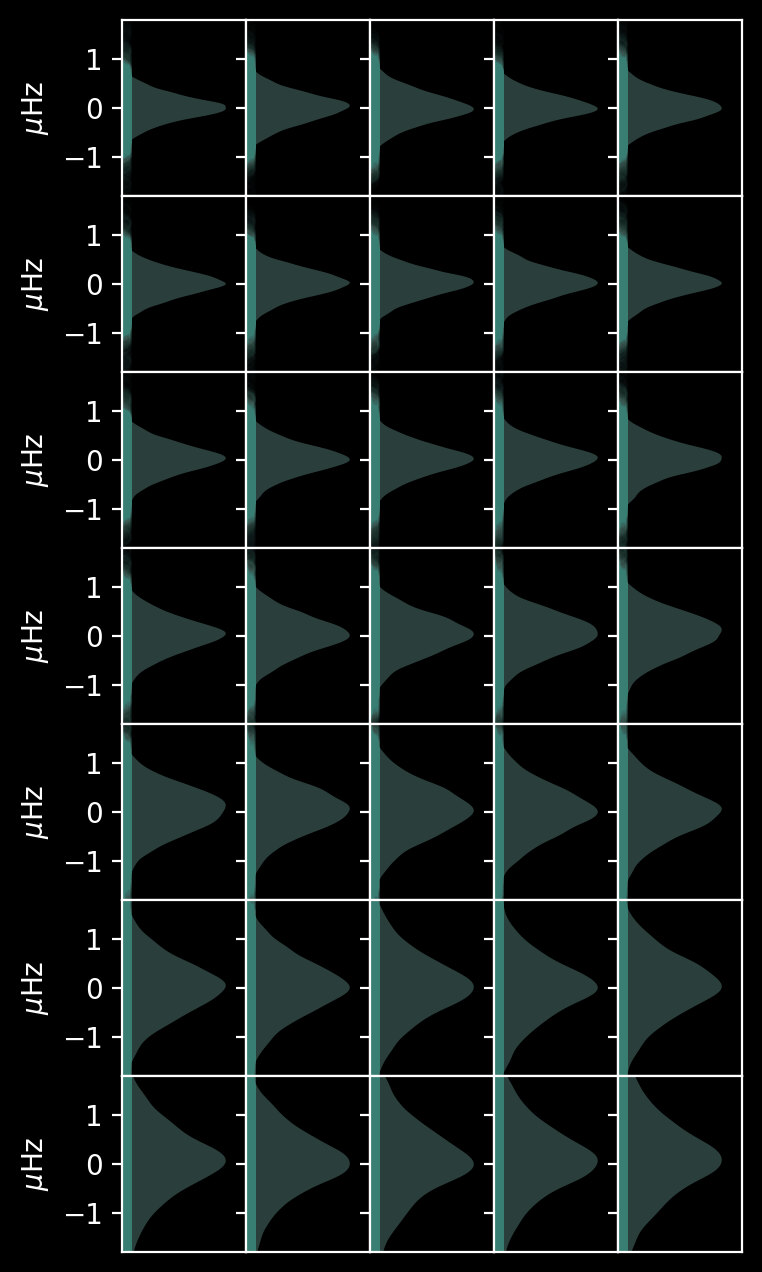

In [466]:
# Network astero output distributions


def astero_violins(df, labels, sample_n=10000):
    df = df.sample(n=sample_n)

    fig, axs = plt.subplots(7, 5, figsize=(4, 8), dpi=200)

    def astero_violin(ax, label):
        residuals = df["resid_" + label]

        median = np.median(residuals, axis=0)
        violin = ax.violinplot(
            residuals,
            showextrema=False,
            showmedians=False,
            points=500,
            widths=1.5,
        )

        body = violin["bodies"][0]
        m = np.mean(body.get_paths()[0].vertices[:, 0])
        body.get_paths()[0].vertices[:, 0] = np.clip(
            body.get_paths()[0].vertices[:, 0], m, np.inf
        )

        ax.scatter(np.ones(len(residuals)), residuals, alpha=0.01)

        # c = "white"
        # ax.scatter(
        #     1,
        #     median + scipy.stats.median_abs_deviation(residuals),
        #     marker="_",
        #     c=c,
        #     s=100,
        # )
        # ax.scatter(
        #     1,
        #     median - scipy.stats.median_abs_deviation(residuals),
        #     marker="_",
        #     c=c,
        #     s=100,
        # )

        ax.xaxis.set_tick_params(labelbottom=False)
        ax.set_xticks([])
        ax.set_xlim([1, 1.9])
        ax.set_ylim([-1.8, 1.8])


    ax_i = 0
    ax_j = 0
    for label_idx in range(len(labels)):
        label = labels[label_idx]
        ax = axs[ax_i,ax_j]
        
        astero_violin(ax, label)

        if ax_j != 0:
            ax.yaxis.set_tick_params(labelleft=False)

        else:
            ax.set_ylabel(r'$\mu$Hz')


        
        ax_j += 1
        if ax_j == 5:
            ax_i += 1
            ax_j = 0

    fig.subplots_adjust(hspace=0, wspace=0)


astero_violins(df, [f"nu_0_{i}" for i in range(6, 41)])